In [ ]:
from google.colab import drive
from pathlib import Path
drive.mount("/content/drive", force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
!cp /content/drive/My\ Drive/comma/orig.zip .
!cp /content/drive/My\ Drive/comma/mean_speeds .
!cp /content/drive/My\ Drive/comma/test.zip .
!cp -r /content/drive/My\ Drive/comma/checkpoint_final normal
!cp -r /content/drive/My\ Drive/comma/checkpoint log

In [ ]:
!unzip orig.zip
!unzip test.zip

Streaming output truncated to the last 5000 lines.
  inflating: test_flow/flow_7898.jpg  
  inflating: test_flow/flow_8567.jpg  
  inflating: test_flow/flow_7654.jpg  
  inflating: test_flow/flow_1225.jpg  
  inflating: test_flow/flow_9679.jpg  
  inflating: test_flow/flow_5043.jpg  
  inflating: test_flow/flow_660.jpg  
  inflating: test_flow/flow_3432.jpg  
  inflating: test_flow/flow_10066.jpg  
  inflating: test_flow/flow_10700.jpg  
  inflating: test_flow/flow_3354.jpg  
  inflating: test_flow/flow_5725.jpg  
  inflating: test_flow/flow_106.jpg  
  inflating: test_flow/flow_1543.jpg  
  inflating: test_flow/flow_8201.jpg  
  inflating: test_flow/flow_7132.jpg  
  inflating: test_flow/flow_10728.jpg  
  inflating: test_flow/flow_4413.jpg  
  inflating: test_flow/flow_2062.jpg  
  inflating: test_flow/flow_6204.jpg  
  inflating: test_flow/flow_9137.jpg  
  inflating: test_flow/flow_8229.jpg  
  inflating: test_flow/flow_9889.jpg  
  inflating: test_flow/flow_6562.jpg  
  inflating:

In [ ]:
import re
import pickle
import glob
import tensorflow as tf
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import cv2 as cv

from collections import Counter, defaultdict

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [ ]:
tf.random.set_seed(1)

In [ ]:
def natural_sort(l): 
    convert = lambda text: int(text) if text.isdigit() else text.lower() 
    alphanum_key = lambda key: [ convert(c) for c in re.split('([0-9]+)', key) ] 
    return sorted(l, key = alphanum_key)

In [ ]:
train_images = natural_sort(glob.glob('flow/flow*jpg'))
with open('mean_speeds', 'rb') as f:
    train_speeds = pickle.load(f)

assert len(train_images) == len(train_speeds), f"Images {len(train_images)}, Speeds {len(train_speeds)}"

In [ ]:
def format_example(image, speed):
  image_string = tf.io.read_file(image)
  image_decoded = tf.image.decode_jpeg(image_string, channels=3)
  image = tf.cast(image_decoded, tf.float32)
  image = (image/127.5) - 1
  image = tf.clip_by_value(image, -1, 1)
  image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE,))
  return image, speed

In [ ]:
IMG_SIZE = 224
BATCH_SIZE = 32

In [ ]:
full_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_speeds))
full_dataset = full_dataset.map(format_example)
full_dataset = full_dataset.batch(BATCH_SIZE)
full_dataset = full_dataset.prefetch(tf.data.experimental.AUTOTUNE)

In [ ]:
normal = tf.keras.models.load_model('normal')
log = tf.keras.models.load_model('log')

In [ ]:
normal_pred = normal.predict(full_dataset, verbose=1)

log_pred = log.predict(full_dataset, verbose=1)

log_pred = [np.exp(s) - 1 for s in log_pred]

638/638 [==============================] - 60s 95ms/step


In [ ]:
pd.DataFrame(normal_pred).describe()

,0
count,20399.000000
mean,12.140277
std,7.974275
min,-1.250885
25%,5.395649
50%,10.650267
75%,20.788075
max,27.864828


In [ ]:
pd.DataFrame(log_pred).describe()

,0
count,20399.000000
mean,12.157675
std,8.207131
min,-0.252969
25%,5.026571
50%,10.646305
75%,20.214697
max,37.298923


In [ ]:
normal_pred = np.maximum(normal_pred, 0)
log_pred = np.maximum(log_pred, 0)

In [ ]:
pd.DataFrame(normal_pred).describe()

,0
count,20399.000000
mean,12.145091
std,7.966779
min,0.000000
25%,5.395649
50%,10.650267
75%,20.788075
max,27.864828


In [ ]:
pd.DataFrame(log_pred).describe()

,0
count,20399.000000
mean,12.158466
std,8.206007
min,0.000000
25%,5.026571
50%,10.646305
75%,20.214697
max,37.298923


In [ ]:
n_df = pd.DataFrame(normal_pred)
l_df = pd.DataFrame(log_pred)

print(n_df.head())
print(l_df.head())

           0
0  24.863541
1  26.327778
2  24.803930
3  23.296762
4  25.169592
           0
0  26.787893
1  26.668495
2  23.300285
3  25.026064
4  27.486542


In [ ]:
n_rolling_windows = n_df.ewm(10, min_periods=1)
n_rolling_mean = n_rolling_windows.mean()

n_mean = n_rolling_mean[0].to_list()

l_rolling_windows = l_df.ewm(10, min_periods=1)
l_rolling_mean = l_rolling_windows.mean()

l_mean = l_rolling_mean[0].to_list()

In [ ]:
total = np.mean([l_mean, n_mean], axis=0)

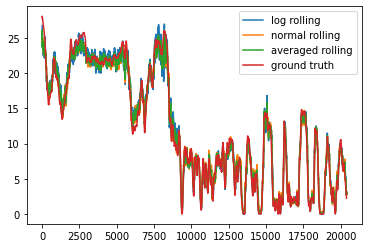

In [ ]:
plt.plot(l_mean, label='log rolling')
plt.plot(n_mean, label='normal rolling')
plt.plot(total, label='averaged rolling')
plt.plot(train_speeds, label='ground truth')
plt.legend()
plt.savefig('averaged_preds_train')

In [ ]:
error = [(total[i]-train_speeds[i])**2 for i in range(len(total))]

In [ ]:
np.mean(error)

0.8132434304153031

In [ ]:
rolling_losses = defaultdict(list)

for i in range(len(total)):
  err = (total[i]-train_speeds[i])**2
  rolling_losses[int(round(train_speeds[i]))].append(err)

In [ ]:
rolling_mse = {k: np.mean(v) for k,v in rolling_losses.items()}


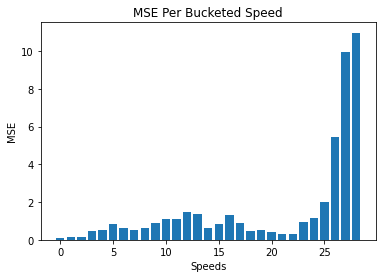

In [ ]:
plt.bar(list(rolling_mse.keys()), list(rolling_mse.values()))
plt.xlabel("Speeds")
plt.ylabel("MSE")
plt.title("MSE Per Bucketed Speed")
plt.savefig('averaged_mse_bucketed')

In [ ]:
test_images = natural_sort(glob.glob('test_flow/flow*jpg'))
test_images[:10]

['test_flow/flow_0.jpg',
 'test_flow/flow_1.jpg',
 'test_flow/flow_2.jpg',
 'test_flow/flow_3.jpg',
 'test_flow/flow_4.jpg',
 'test_flow/flow_5.jpg',
 'test_flow/flow_6.jpg',
 'test_flow/flow_7.jpg',
 'test_flow/flow_8.jpg',
 'test_flow/flow_9.jpg']

In [ ]:
empty = np.zeros(len(test_images))
empty

array([0., 0., 0., ..., 0., 0., 0.])

In [ ]:
test_dataset = tf.data.Dataset.from_tensor_slices((test_images, empty))
test_dataset = test_dataset.map(format_example)
test_dataset = test_dataset.batch(BATCH_SIZE)
test_dataset = test_dataset.prefetch(tf.data.experimental.AUTOTUNE)

In [ ]:
normal_pred = normal.predict(test_dataset, verbose=1)

log_pred = log.predict(test_dataset, verbose=1)

log_pred = [np.exp(s) - 1 for s in log_pred]

338/338 [==============================] - 34s 101ms/step


In [ ]:
pd.DataFrame(normal_pred).describe()

,0
count,10797.000000
mean,11.063000
std,5.553017
min,-1.179539
25%,8.199678
50%,10.929945
75%,14.100049
max,26.688881


In [ ]:
pd.DataFrame(log_pred).describe()

,0
count,10797.000000
mean,10.420864
std,5.431248
min,-0.269082
25%,7.200810
50%,10.373094
75%,13.644015
max,31.293823


In [ ]:
normal_pred = np.maximum(normal_pred, 0)
log_pred = np.maximum(log_pred, 0)

In [ ]:
n_df = pd.DataFrame(normal_pred)
l_df = pd.DataFrame(log_pred)

print(n_df.head())
print(l_df.head())

           0
0  10.358444
1   4.815517
2   7.136837
3   8.797113
4   8.789436
           0
0   4.483523
1  12.601213
2   8.142741
3  13.154553
4   5.373078


In [ ]:
n_rolling_windows = n_df.ewm(10, min_periods=1)
n_rolling_mean = n_rolling_windows.mean()

n_mean = n_rolling_mean[0].to_list()

l_rolling_windows = l_df.ewm(10, min_periods=1)
l_rolling_mean = l_rolling_windows.mean()

l_mean = l_rolling_mean[0].to_list()

In [ ]:
total = np.mean([l_mean, n_mean], axis=0)

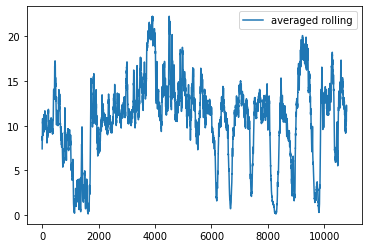

In [ ]:
plt.plot(total, label='averaged rolling')
plt.legend()
plt.savefig('test_predictions')

In [152]:
total = np.append(total, total[-1])
len(total)

10798

In [153]:
np.savetxt('test.txt', total)